In [1]:
bigpage = True
from IPython.core.display import display, HTML
if bigpage:
    display(HTML("<style>.container { width:90% !important; }</style>"))
else:
    display(HTML("<style>.container { width:1140px !important; }</style>"))

In [2]:
from continuum_example import X, y, file_prefix, n, alpha
from numpy import (log10, sqrt, maximum, minimum, median, pi, arccos, load, argsort,
                   concatenate, array, empty, linalg, linspace, unravel_index, arange)
%matplotlib notebook
# %matplotlib qt
from matplotlib import pyplot as plt
from FFT_simulator import getFTpoints, planes2basis
from utils import loadmat
from cycler import cycler
import pyxem as pxm
# from pyxem.generators.subpixelrefinement_generator import SubpixelrefinementGenerator
from subpixelrefinement_generator import SubpixelrefinementGenerator
from hyperspy.api import preferences; preferences.General.show_progressbar = False

clist, slist = list('bgrmkcy'), ['-', '--', ':', '-.']
plt.rc('axes', prop_cycle=(cycler('color', clist*len(slist)) + cycler('linestyle', slist*len(clist))))
if bigpage:
    plt.rcParams['figure.figsize'] = [14.9, 6]
else:
    plt.rcParams['figure.figsize'] = [9.5, 6]
def figure(name, *args, **kwargs):
    plt.close(name); f = plt.figure(name, *args, **kwargs);return f

n, alpha, rotate = n[0], 2, False
filename = file_prefix + '_' + str(n) + '_' + str(alpha)

def plot_FT(thing, *args, origin='lower', **kwargs):
    if thing.ndim == 2:
        plt.imshow(thing, *args, aspect='equal', extent=[y[0][0], y[0][-1], y[1][0], y[1][-1]], origin=origin, **kwargs)
    else:
        plt.plot(y[0], thing, *args, **kwargs)

sqrt = lambda x: x ** .5
def norm(*x):
    if len(x) == 1:
        x = x[0]
    return sqrt(abs(x[0])**2+abs(x[1])**2)

def padSpots(s):
    if s.shape[-1] == 3:
        return s
    else:
        S = empty(s.shape[:-1]+(3,))
        S[...,:2], S[...,2] = s, 0
        return S

In [3]:
print(filename)
gt = loadmat(filename + '_gt', 'precessed', 'flat')
gt = gt[0][0,0,0]/gt[0].max(), gt[1][0,0,0]/gt[1].max()

precessed, flat = loadmat(filename, 'precessed', 'flat')
precessed, flat = precessed[0], flat[0]
precessed /= precessed.max(axis=(-1,-2), keepdims=True)
flat /= flat.max(axis=(-1,-2), keepdims=True)

strain, = loadmat(filename + '_strain', 'strain')

inv_strain = empty(strain.shape, dtype='object')
for i in range(strain.shape[0]):
    for j in range(strain.shape[1]):
        inv_strain[i,j] = linalg.inv(strain[i,j])

# in (y,x) format
spots = concatenate((2.32*array([[1,1], [1,-1], [-1,1],[-1,-1]]), 4.66*array([[0,1], [0,-1], [-1,0],[1,0]])), axis=0)
spots = spots[:,::-1] # in (x,y) format

sim/analytic_450_2


<IPython.core.display.Javascript object>


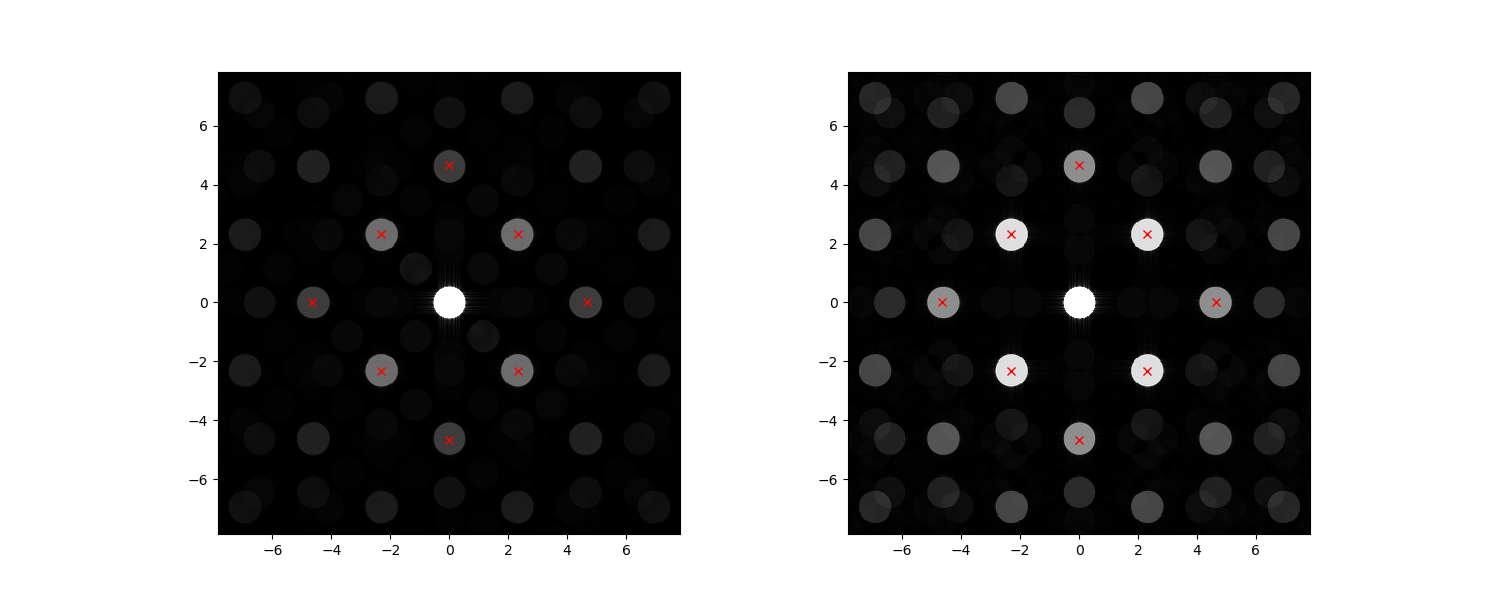

In [4]:
thresh, scale =.1, lambda x: maximum(1e-10,minimum(x,thresh)**.4)
figure('GT')
plt.subplot(121); plot_FT(scale(gt[0]))
plt.plot(spots[:,0], spots[:,1], 'rx')
plt.subplot(122); plot_FT(scale(gt[1]))
plt.plot(spots[:,0], spots[:,1], 'rx')

<IPython.core.display.Javascript object>


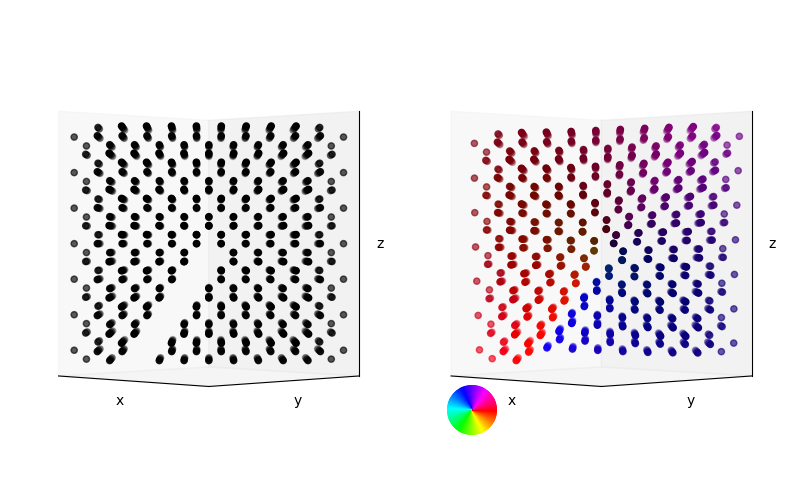

/home/rob/anaconda3/envs/strain/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import pyplot as plt
from numpy import arctan2
from continuum_example import crystal, slice_atoms, strain_map, spacing, getSiBlock
base_crystal = crystal(spacing*getSiBlock(width=8), 14)
base_crystal = base_crystal.translate(-(base_crystal.box[:, 1] / 2 // spacing) * spacing)
base_crystal = base_crystal.translate([-.5 * spacing, -.5 * spacing, 0])
b, u = [spacing / 6 ** .5] * 3, [1, -1, 0]
slice_crystal = crystal(slice_atoms(base_crystal.loc, b, u), 14)
strained_crystal = crystal(strain_map(slice_crystal.loc, b, u), 14)

ticks, lims = [], (-16, 16)
fig = figure('crystal', figsize=(8,5))
ax = fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')

ind = [i for i,d in enumerate(slice_crystal.loc) if abs(d[0])<15 and abs(d[1])<15 and abs(d[2])<20 and abs(d[0]-d[1])<10]
d0 = array([slice_crystal.loc[i] for i in ind]).T
d1 = array([strained_crystal.loc[i] for i in ind]).T
ax[0].scatter(*d0, color='k'); 
# ax[1].scatter(*d1, c=abs((d0-d1)**2).sum(0)**.5, cmap='winter');
# cmap = mpl.colors.LinearSegmentedColormap('bkr', {'red':   ((0.0, 0.0, 0.0), (0.5, 0.0, 0.1), (1.0, 1.0, 1.0)),
#          'green': ((0.0, 0.0, 0.0), (1.0, 0.0, 0.0)),
#          'blue':  ((0.0, 0.0, 1.0), (0.5, 0.1, 0.0), (1.0, 0.0, 0.0))})
cmap = plt.get_cmap('hsv')
def d2c(d):
    xy,z = (d[0]+d[1])/2**.5, d[2]
    a = arctan2(z,-xy)/3.14159/2
    if a<0:
        a+=1
    c = cmap(1-a)
#     return c
    n = (xy**2+z**2)**.6#/sum(cc**2 for cc in c[:3])**.5
    return (c[0]*n,c[1]*n,c[2]*n)

c = array([d2c(d) for d in (d1-d0).T])
c/=c.max()
# squeeze = lambda x: x/abs(x)*((d0-d1)**2).sum(0)**.5
# ax[1].scatter(*d1, c=squeeze((d0-d1)[:2].sum(0)), cmap=cmap);
ax[1].scatter(*d1, c=c);

display_axes = fig.add_axes([0.54,0.13,0.1,0.1], projection='polar')
# display_axes._direction = 2*3.14159
norm = mpl.colors.Normalize(0.0, 2*3.14159)
cb = mpl.colorbar.ColorbarBase(display_axes, cmap=plt.get_cmap('hsv',180).reversed(), norm=norm, orientation='horizontal')
cb.outline.set_visible(False)                                 
display_axes.set_axis_off()

# loc = array([[x,x,z] for x in range(-15,16,2) for z in range(-18,19,3) if abs(2*x+z)>4 or z>0])+.5
# d0 = loc.T
# d1 = strain_map(loc, b, u).T
# ax[0].quiver(*d0, *(d1-d0), length=1, normalize=False, color='red', arrow_length_ratio=.5)
for a in ax:
    a.view_init(0, 135);
    a.set_xticks(ticks); a.set_yticks(ticks); a.set_zticks(ticks)
    a.set_xlim(lims); a.set_ylim(lims)
    a.set_xlabel('x'); a.set_ylabel('y'); a.set_zlabel('z')
    a.xaxis.labelpad=-10; a.yaxis.labelpad=-10; a.zaxis.labelpad=-10
plt.tight_layout()
plt.savefig('dislocation_phantom.png', dpi=300)

In [6]:
spot_rad = 0.55, .85 # radius of spot, distance from center of one spot to edge of the next

def predict(spots, strain):
    SPOTS = padSpots(spots[:,:2]) # [:,(x,y,z)] format
    SPOTS = SPOTS[:,(1,0,2)] # [:,ax=(0,1,2)] format
    scatter = empty(strain.shape[:2]+(spots.shape[0],), dtype=object)
    out = empty(strain.shape[:2]+(spots.shape[0],2))
    for i in range(strain.shape[0]):
        for j in range(strain.shape[1]):
            for l in range(spots.shape[0]):
                scatter[i,j,l] = array([linalg.solve(s.T, SPOTS[l])[1::-1] for s in strain[i,j]])
                out[i,j,l] = sum(scatter[i,j,l])/strain[i,j].shape[0]
    return scatter, out

def getCOMs(arr, points, method='com', reference=None):
    # Assume points in [:,(x,y)] format
    # returns points in [:,(x,y)] format
    insz = arr.shape
    
    signal = pxm.ElectronDiffraction2D(arr.reshape((-1,)+insz[-3:]))
    signal.set_diffraction_calibration(y[0][1]-y[0][0])

    midsz = signal.data.shape
    if points.ndim == 2:
        spg = SubpixelrefinementGenerator(signal, points)
    else:
        tmp = pxm.DiffractionVectors(points.reshape(midsz[:2]+(-1,2)))
        tmp.axes_manager.set_signal_dimension(2)
        spg = SubpixelrefinementGenerator(signal, tmp)
    
    if method == 'com':
        peaks = spg.center_of_mass_method(2*int(spot_rad[1]/(y[1][1]-y[1][0])))
    elif method == 'lgm':
        peaks = spg.local_gaussian_method(2*int(spot_rad[1]/(y[1][1]-y[1][0])))
    elif method == 'xc':
        peaks = spg.conventional_xc(2*int(spot_rad[1]/(y[1][1]-y[1][0])), 
                                    int(spot_rad[0]/(y[1][1]-y[1][0])),
                                    30)
    elif method == 'rxc':
        peaks = spg.reference_xc(reference,
                                 2*int(spot_rad[1]/(y[1][1]-y[1][0])), 
                                 30)
    else:
        raise NotImplementedError("Your method, %s, is not currently supported.\nPlease choose from 'com', 'lgm', and 'xc'"%method)
        
    return peaks.data.reshape(*insz[:-2],-1,2)

names = ['precessed', 'flat', 'sqrt precessed', 'sqrt flat',
         'precessed xc', 'flat xc', 'sqrt precessed xc', 'sqrt flat xc',
         'precessed rxc', 'flat rxc', 'sqrt precessed rxc', 'sqrt flat rxc']
coms = {name: None for name in names}
coms.update({'exact '+name: None for name in names})

for name in names:
    ref = gt[0]
    if 'precessed' in name:
        arr = precessed
    else:
        arr, ref = flat, gt[1]
    if 'sqrt' in name:
        arr = sqrt(arr)
    print('starting '+ name)
    if 'rxc' in name:
        coms['exact '+name] = getCOMs(ref, spots, 'xc')
        coms['exact '+name] = getCOMs(ref, coms['exact '+name], 'rxc', ref)
        coms[name] = getCOMs(arr, coms['exact '+name], 'rxc', ref)
    else:
        coms['exact '+name] = getCOMs(ref, spots, 'xc' if 'xc' in name else 'com')
        coms[name] = getCOMs(arr, coms['exact '+name], 'xc' if 'xc' in name else 'com')

print('Centres complete')

scatter, predicted = {name:None for name in names}, {name:None for name in names}
for name in names:
    scatter[name], predicted[name] = predict(coms['exact '+name], strain)
print('Strained centres complete')

starting precessed
starting flat
starting sqrt precessed
starting sqrt flat
starting precessed xc
starting flat xc
starting sqrt precessed xc
starting sqrt flat xc
starting precessed rxc
starting flat rxc
starting sqrt precessed rxc
starting sqrt flat rxc
Centres complete
Strained centres complete


In [7]:
pixel_error = 0.0*max(abs(y[0][1]-y[0][0]), abs(y[1][1]-y[1][0])) # This error will be rounded to 0

def correctShapes(list1,list2,cut=False):
    if list1.ndim < list2.ndim:
        out1,out2 = list1.reshape(*((1,)*(list2.ndim-list1.ndim) + list1.shape)), list2
    elif list1.ndim > list2.ndim:
        out1,out2 = list1, list2.reshape(*((1,)*(list1.ndim-list2.ndim) + list2.shape))
    else:
        out1,out2 = list1,list2
    if cut:
        return out1[...,:2], out2[...,:2]
    else:
        return out1, out2

def L2error(list1, list2):
    list1,list2 = correctShapes(list1,list2, cut=True)
    return maximum(0, sqrt(((list1-list2)**2).sum(-1))-pixel_error)/(1e-10+sqrt((list1**2).sum(-1)))

def angularerror(list1, list2): 
    list1,list2 = correctShapes(list1,list2, cut=True)
    thing = (list1*list2).sum(-1)
    r2 = maximum(1e-6, sqrt((list1**2).sum(-1)*(list2**2).sum(-1)))
    thing = minimum(thing/r2, 1)
    return maximum(0, arccos(thing)-pixel_error/r2**.5)/pi

def radialerror(list1, list2):
    list1,list2 = correctShapes(list1,list2, cut=True)
    r1, r2 = sqrt((list1**2).sum(-1)), sqrt((list2**2).sum(-1))
    tmp = r1-r2
    tmp[tmp>0] = maximum(0,tmp[tmp>0]-pixel_error)
    tmp[tmp<0] = minimum(0,tmp[tmp<0]+pixel_error)
    return tmp/r1

def HEADER(): print('|      Label      | Median |  Mean  |   STD  |   max  |\n'+'-'*55)
def FOOTER(): print('-'*55)
def PRINT(S,A): print('|%16.16s | % .3f | % .3f | % .3f | % .3f |'%(S, median(A), A.mean(), A.std(), abs(A).max()))
def TABLE(S,a,A): 
    frmt = '|%16.16s |  %.2f%% |  %.2f%% |  %.3f%% |  %.3f%% |  %+.3f%%  |   %.2f%%  |'
    n = [S]
    for func in (L2error,angularerror, radialerror):
        B = 100*func(a,A)
#         print(' % .3f%% | % .3f%% | % .3f%% |'%(B.mean(), median(B), B.std()), end='')
        n.extend(((median(B)+B.mean())/2, B.std()))
    print(frmt%tuple(n))


def plotError(ax, arr, m, extra=['','']):
    out = ax.imshow(arr.mean(-1), interpolation='nearest', vmin=m[0], vmax=m[1], origin='lower',
              extent=[.5*(3*X[0][0]-X[0][1]), .5*(3*X[0][-1]-X[0][-2]),
                      .5*(3*X[1][0]-X[1][1]), .5*(3*X[1][-1]-X[1][-2])])
    ax.set_title(extra[1] if len(extra[1])>0 else 'Errors')
    return out

56


<IPython.core.display.Javascript object>


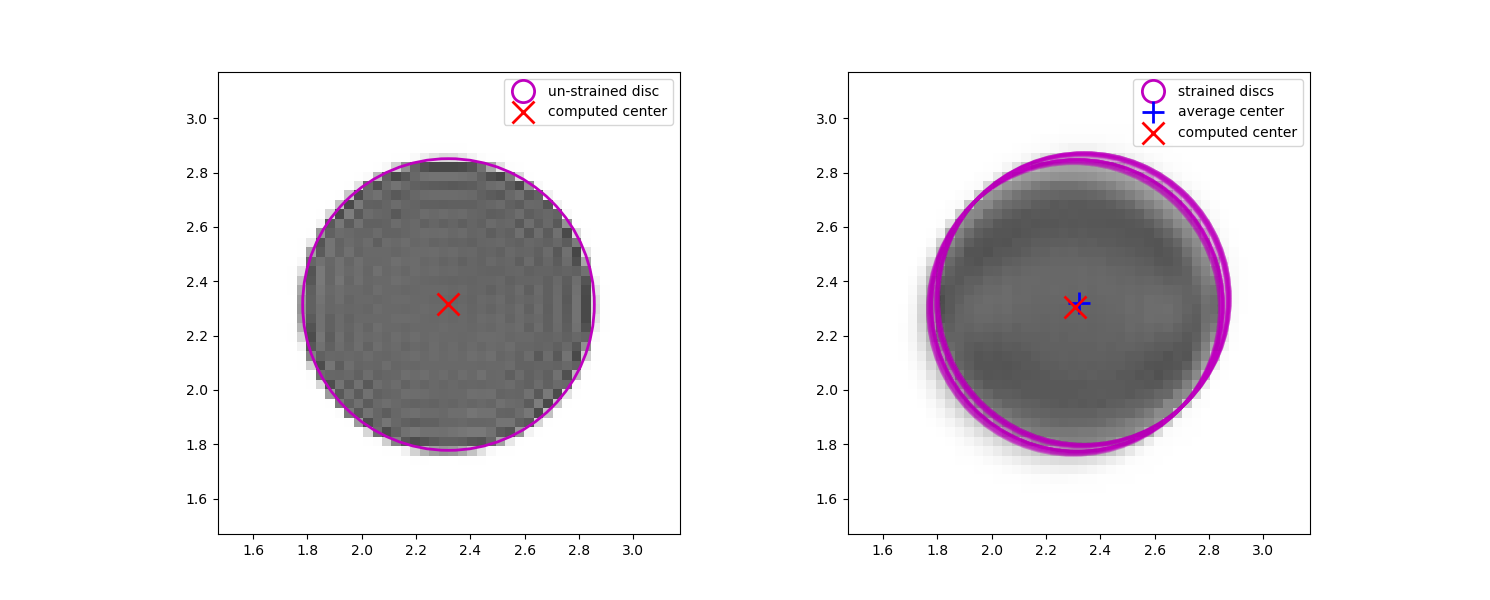

In [19]:
size, name =1, 'precessed'
k = L2error(predicted[name][:2], coms[name][:2]).argmax()
# k = argsort(L2error(predicted[name], coms[name]).reshape(-1))[-3]
print(k)
i,j,bad_spot = unravel_index(k,predicted[name].shape[:3])

figure('Predicted and computed spot locations')
thresh, scale = .08 if rotate else .02, lambda x: maximum(0,minimum(x,thresh)**1)
plt.subplot(121); plot_FT(-scale(gt[1 if 'flat' in name else 0]), cmap='gray')
if size==0: # small
    this_spot = spots[bad_spot]
    ax = this_spot-.2*spot_rad[1], this_spot+.2*spot_rad[1]
    pms = {'markersize':16,'mew':2}
elif size==1: # medium
    this_spot = spots[bad_spot]
    ax = this_spot-spot_rad[1], this_spot+spot_rad[1]
    pms = {'markersize':16,'mew':2}
else: # large
    ax = [(-6,-6),(6,6)]
    pms = {'markersize':8,'mew':2}
ax = ax[0][0], ax[1][0], ax[0][1], ax[1][1]
if size==1:
    plt.plot(coms['exact '+name][:,0], coms['exact '+name][:,1],'mo', label='un-strained disc', fillstyle='none', markersize=210, mew=2, alpha=1)
plt.plot(coms['exact '+name][:,0], coms['exact '+name][:,1], 'rx', label='computed center', **pms)
plt.axis(ax); lgnd=plt.legend(); # plt.title('Unstrained sample')
lgnd.legendHandles[0]._legmarker.set_markersize(pms['markersize']); lgnd.legendHandles[0]._legmarker.set_alpha(1)

plt.subplot(122); plot_FT(-scale((flat if 'flat' in name else precessed)[i,j]), cmap='gray')
if size==0: # small
    s = concatenate(scatter[name][i,j])
    this_spot = predicted[name][i,j,bad_spot]
    ax = this_spot-.2*spot_rad[1], this_spot+.2*spot_rad[1]
    f_name = '_big_zoom'
elif size==1: # medium
    s = concatenate(scatter[name][i,j])
    this_spot = spots[bad_spot]
    ax = this_spot-spot_rad[1], this_spot+spot_rad[1]
    f_name = '_zoom'
else: # large
    ax = [(-6,-6),(6,6)]
    f_name = ''
ax = ax[0][0], ax[1][0], ax[0][1], ax[1][1]
plt.axis(ax)
if size==0:
    plt.plot(s[:,0], s[:,1],'m*', label='strained centers', **pms)
elif size==1:
    plt.plot(s[:,0], s[:,1],'mo', label='strained discs', fillstyle='none', markersize=210, mew=2, alpha=.1)
plt.plot(predicted[name][i,j,:,0], predicted[name][i,j,:,1], 'b+', label='average center', **pms)
plt.plot(coms[name][i,j,:,0], coms[name][i,j,:,1], 'rx', label='computed center', **pms)
lgnd = plt.legend(); lgnd.legendHandles[0]._legmarker.set_markersize(pms['markersize']); lgnd.legendHandles[0]._legmarker.set_alpha(1)
# plt.title('Worst strained sample')
if alpha==2 and rotate==False:
    plt.savefig('/home/rob/Dropbox (Cambridge University)/2018_strainTomography/Publications/Theory/Images/bad_prediction_cont' + f_name + '.png', dpi=300)

In [12]:
funcs = [(L2error, 'Location error'),
        (angularerror, 'Angle error'),
        (radialerror, 'Radial error')]
names = [['precessed', 'plain', 'plain'], ['sqrt precessed', '(sqrt)', 'with sqrt'],
        ['precessed xc', 'plain xc', 'plain xc'], ['sqrt precessed xc', '(sqrt xc)', 'with sqrt xc'],
        ['precessed rxc', 'plain rxc', 'plain rxc'], ['sqrt precessed rxc', '(sqrt rxc)', 'with sqrt rxc']]


# for f in funcs:
#     figure(f[1], figsize=(14.9, 6))

# for f in funcs:
#     fig, ax = plt.subplots(len(names)//3, 3, num=f[1])
#     m = (min(100*f[0](predicted[name[0]], coms[name[0]]).mean(1).min() for name in names), 
#          max(100*f[0](predicted[name[0]], coms[name[0]]).mean(1).max() for name in names))
#     for i,name in enumerate(names):
#         tmp = plotError(ax.item(i), 100*f[0](predicted[name[0]], coms[name[0]]),
#                 m, name[1:])
#     plt.tight_layout(); #FOOTER()

#     c_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
#     cbar = fig.colorbar(tmp, cax=c_ax)


### Accuracy of linear strain COMs for hyperplane model (independent of $\alpha$)
| <pre>   </pre> | L2 err | L2 std |Angle err|Angle std|Radial bias|Radial std|
|----------------|--------|--------|---------|---------|-----------|----------|
|  Plain COMs     |  0.23% |  0.30% |  0.021% |  0.052% |  +0.078%  |   0.33%  |
|  Sqrt COMs      |  0.14% |  0.16% |  0.019% |  0.027% |  +0.069%  |   0.18%  |
|  Plain XC       |  0.19% |  0.20% |  0.027% |  0.038% |  +0.043%  |   0.23%  |
|  Sqrt XC        |  0.17% |  0.19% |  0.019% |  0.035% |  +0.043%  |   0.22%  |
|  Plain RXC      |  0.20% |  0.22% |  0.028% |  0.040% |  +0.067%  |   0.26%  |
|  Sqrt RXC       |  0.21% |  0.22% |  0.028% |  0.040% |  +0.045%  |   0.26%  |

--------------------------------------------------------------------------------------
## $\alpha = 1$
| <pre>    </pre> | L2 err | L2 std |Angle err|Angle std|Radial bias|Radial std|
|-----------------|--------|--------|---------|---------|-----------|----------|
|  Plain COMs     |  0.55% |  0.49% |  0.010% |  0.023% |  +0.539%  |   0.49%  |
|  Sqrt COMs      |  0.56% |  0.31% |  0.018% |  0.028% |  +0.550%  |   0.31%  |
|  Plain XC       |  0.09% |  0.10% |  0.008% |  0.019% |  -0.016%  |   0.11%  |
|  Sqrt XC        |  0.08% |  0.10% |  0.007% |  0.019% |  -0.012%  |   0.11%  |
|  Plain RXC      |  0.12% |  0.11% |  0.007% |  0.017% |  +0.053%  |   0.13%  |
|  Sqrt RXC       |  0.11% |  0.10% |  0.007% |  0.017% |  +0.032%  |   0.13%  |

--------------------------------------------------------------------------------------
## $\alpha = 2$
| <pre>    </pre> | L2 err | L2 std |Angle err|Angle std|Radial bias|Radial std|
|-----------------|--------|--------|---------|---------|-----------|----------|
|  Plain COMs     |  0.12% |  0.16% |  0.012% |  0.028% |  +0.008%  |   0.20%  |
|  Sqrt COMs      |  0.17% |  0.16% |  0.019% |  0.030% |  +0.087%  |   0.19%  |
|  Plain XC       |  0.10% |  0.12% |  0.012% |  0.021% |  -0.001%  |   0.15%  |
|  Sqrt XC        |  0.11% |  0.11% |  0.013% |  0.021% |  -0.006%  |   0.14%  |
|  Plain RXC      |  0.08% |  0.11% |  0.007% |  0.020% |  -0.019%  |   0.12%  |
|  Sqrt RXC       |  0.08% |  0.12% |  0.008% |  0.021% |  -0.022%  |   0.13%  |

In [9]:
names = [[' Plain COMs    ','precessed'], [' Sqrt COMs     ','sqrt precessed'], [' Plain XC      ', 'precessed xc'], 
         [' Sqrt XC       ', 'sqrt precessed xc'], [' Plain RXC     ', 'precessed rxc'], [' Sqrt RXC      ', 'sqrt precessed rxc']]
print('alpha=%.1f'%alpha)
print('Strain prediction precessed')
for name in names:
    TABLE(name[0], predicted[name[1]], coms[name[1]])

print('\nalpha=%.1f'%0)
print('Strain error from flat')
for name in names:
    TABLE(name[0], predicted[name[1].replace('precessed','flat')], coms[name[1].replace('precessed','flat')])


alpha=2.0
Strain prediction precessed
|  Plain COMs     |  0.12% |  0.16% |  0.012% |  0.028% |  +0.008%  |   0.20%  |
|  Sqrt COMs      |  0.17% |  0.16% |  0.019% |  0.030% |  +0.087%  |   0.19%  |
|  Plain XC       |  0.10% |  0.12% |  0.012% |  0.021% |  -0.001%  |   0.15%  |
|  Sqrt XC        |  0.11% |  0.11% |  0.013% |  0.021% |  -0.006%  |   0.14%  |
|  Plain RXC      |  0.08% |  0.11% |  0.007% |  0.020% |  -0.019%  |   0.12%  |
|  Sqrt RXC       |  0.08% |  0.12% |  0.008% |  0.021% |  -0.022%  |   0.13%  |

alpha=0.0
Strain error from flat
|  Plain COMs     |  0.23% |  0.30% |  0.020% |  0.052% |  +0.072%  |   0.33%  |
|  Sqrt COMs      |  0.13% |  0.15% |  0.018% |  0.025% |  +0.068%  |   0.18%  |
|  Plain XC       |  0.25% |  0.36% |  0.029% |  0.062% |  +0.074%  |   0.40%  |
|  Sqrt XC        |  0.25% |  0.33% |  0.031% |  0.056% |  +0.070%  |   0.38%  |
|  Plain RXC      |  0.20% |  0.22% |  0.023% |  0.039% |  +0.060%  |   0.26%  |
|  Sqrt RXC       |  0.21% |  0.22% |